## Projet 6 : Classifier automatiquement des bien de consommation
## <a name="C4"> Partie 2 : étude de faisabilité des features images</a>

Dans le cadre de notre mission en tant que Data Scientist chez "Place de marché", nous avons pour objectif d'automatiser l'attribution des catégories pour les articles proposés sur notre plateforme e-commerce. Actuellement, cette tâche est réalisée manuellement par les vendeurs, ce qui peut engendrer des erreurs et des incohérences. Avec la croissance prévue du volume d'articles, il devient crucial de développer un moteur de classification automatique des articles basé sur leur description textuelle et leur image. Linda, notre Lead Data Scientist, nous a confié la réalisation d'une étude de faisabilité pour ce projet. Cette étude comprendra l'analyse des données textuelles et visuelles, l'extraction de features, et l'évaluation de la possibilité de regrouper les articles par catégorie de manière automatique.

Sommaire :  
   
- Préparation des données
- Segmentation des produits via leur image  
  
Numérisation de l'image : approche Générateur de descripteurs  
- SIFT
  
Numérisation de l'image : approche Réseaux de neurones  
- CNN transfer learning
  
Numérisation de l'image : approches supervisées  
- VGG16
- VGG19
- RESNET50
  
Conclusion

## <a name="C4"> Mise en place de l'environnement de travail</a>

In [9]:
import os
import shutil
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.image import imread
import seaborn as sns
import plotly.express as px
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from plot_keras_history import show_history, plot_history
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import warnings
warnings.filterwarnings("ignore")

print("Librairies importées avec succès !")

Librairies importées avec succès !


In [10]:
print("Version of the libraries used")
print("-----------------------------")
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("Matplotlib:", plt.matplotlib.__version__)
print("Seaborn:", sns.__version__)

Version of the libraries used
-----------------------------
Pandas: 2.2.2
NumPy: 1.26.4
Matplotlib: 3.8.4
Seaborn: 0.13.2


- Création des fonctions utiles

In [11]:
def data_info(df: pd.DataFrame):
    desc = df.columns.to_frame(name="colonne").set_index('colonne')
    desc['nombre de valeurs non nulles'] = df.notnull().sum() 
    desc['nombre de valeurs uniques'] = df.nunique() 
    desc['type de donnée'] = df.dtypes 
    desc['nombre de valeurs nulles']=df.isna().sum()
    desc['pourcentage de valeurs nulles']=round((df.isna().sum()/df.shape[0]*100),2)
    return desc

# Indication de réussite
print("Fonction data_info créée avec succès !")

Fonction data_info créée avec succès !


In [12]:
def fill_rates_plot(dataframe, ignore_columns=None):
    # Filtrer les colonnes si nécessaire
    if ignore_columns is not None:
        dataframe = dataframe.drop(columns=ignore_columns, errors='ignore')

    # Calcul du taux de remplissage pour chaque colonne
    fill_rates = dataframe.notnull().mean() * 100

    # Création de l'histogramme
    plt.figure(figsize=(25, 4))
    fill_rates.plot(kind='bar', color='steelblue')
    plt.title('Taux de remplissage des colonnes')
    plt.xlabel('Colonnes')
    plt.ylabel('Taux de remplissage (%)')
    plt.xticks(rotation=90)
    plt.grid(True, linestyle='--', linewidth=0.5, color='lightsteelblue')
    
    # Affichage de l'histogramme
    plt.show()
    
# Indication de réussite
print("Fonction fill_rates_plot créée avec succès !")

Fonction fill_rates_plot créée avec succès !


- Chargement des données

In [13]:
data = './data/cleaned/'
os.listdir(data)

['df_category.csv']

In [14]:
fn = data + 'df_category.csv'
df_category = pd.read_csv(fn)
df_category

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,overall_rating,brand,product_specifications,category,sub_category_1,sub_category_2,sub_category_3,sub_category_4,sub_category_5,category_id
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56+00:00,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet...,NaN,NaN,4
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56+00:00,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red...",NaN,0
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56+00:00,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE...,NaN,0
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52+00:00,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King siz...,NaN,4
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52+00:00,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double ...,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43+00:00,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,...,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,Baby & Kids Gifts,Stickers,"Oren Empower Stickers""]",NaN,NaN,0
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43+00:00,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,...,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,Baby & Kids Gifts,Stickers,"Wallmantra Stickers""]",NaN,NaN,0
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43+00:00,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35

- Répertoire des images

In [15]:
img_path = r'data/images/'

## <a name="C4"> Préparation des données</a>

- Création des catégories

In [16]:
cat_array = df_category['category'].unique()
cat_array

os.mkdir('Datacat')
os.mkdir('Datacat/train')
os.mkdir('Datacat/test')

base_dir ='Flipkart/images'
train_dir = 'Datacat/train/'
test_dir = 'Datacat/test/'

for i in range (len(cat_array)):
  os.mkdir('Datacat/train/%s' % cat_array[i])
  os.mkdir('Datacat/test/%s' % cat_array[i])

for i in range (len(cat_array)):
  for j in range(len(df_category['category'][df_category['category']==cat_array[i]])) :
    if(j<(len(df_category['category'][df_category['category']==cat_array[0]])*0.9)):
      shutil.copy(base_dir+'/%s' % df_category['image'][df_category['category']==cat_array[i]].values[j], train_dir +'%s' % cat_array[i])
      os.rename(train_dir+'/%s' %cat_array[i]+'/'+ df_category['image'][df_category['category']==cat_array[i]].values[j], train_dir+'%s' %cat_array[i]+'/'+cat_array[i]+'%i'%j+'.jpg')
    else :
      shutil.copy(base_dir+'/%s' % df_category['image'][df_category['category']==cat_array[i]].values[j], test_dir +'%s' % cat_array[i])
      os.rename(test_dir+'/%s' %cat_array[i]+'/'+ df_category['image'][df_category['category']==cat_array[i]].values[j], test_dir+'%s' %cat_array[i]+'/'+cat_array[i]+'%i'%j+'.jpg')

- Création des set d'entrainement et de test

In [17]:
train_dir = 'Datacat/train/'
test_dir = 'Datacat/test/'

def collect_images_and_labels(directory):
    image_paths = []
    labels = []
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            for image in os.listdir(category_path):
                image_paths.append(os.path.join(category_path, image))
                labels.append(category)
    return image_paths, labels

train_image_paths, train_labels = collect_images_and_labels(train_dir)
test_image_paths, test_labels = collect_images_and_labels(test_dir)

train_data = pd.DataFrame({'image_path': train_image_paths, 'label_name': train_labels})
test_data = pd.DataFrame({'image_path': test_image_paths, 'label_name': test_labels})

le = preprocessing.LabelEncoder()
train_data["label"] = le.fit_transform(train_data["label_name"])
test_data["label"] = le.transform(test_data["label_name"])

train_data.sample(10)

,image_path,label_name,label
671,Datacat/train/Home Furnishing\Home Furnishing9...,Home Furnishing,4
164,Datacat/train/Beauty and Personal Care\Beauty ...,Beauty and Personal Care,1
194,Datacat/train/Beauty and Personal Care\Beauty ...,Beauty and Personal Care,1
855,Datacat/train/Watches\Watches18.jpg,Watches,6
808,Datacat/train/Kitchen Dining\Kitchen Dining9...,Kitchen Dining,5
531,Datacat/train/Home Decor Festive Needs\Home D...,Home Decor Festive Needs,3
259,Datacat/train/Beauty and Personal Care\Beauty ...,Beauty and Personal Care,1
862,Datacat/train/Watches\Watches24.jpg,Watches,6
136,Datacat/train/Beauty and Personal Care\Beauty ...,Beauty and Personal Care,1
767,Datacat/train/Kitchen Dining\Kitchen Dining6...,Kitchen Dining,5


In [18]:
test_data.sample(5)

,image_path,label_name,label
71,Datacat/test/Home Furnishing\Home Furnishing14...,Home Furnishing,4
73,Datacat/test/Home Furnishing\Home Furnishing14...,Home Furnishing,4
23,Datacat/test/Beauty and Personal Care\Beauty a...,Beauty and Personal Care,1
25,Datacat/test/Beauty and Personal Care\Beauty a...,Beauty and Personal Care,1
70,Datacat/test/Home Furnishing\Home Furnishing14...,Home Furnishing,4


In [19]:
train_data.groupby("label_name").count()

,image_path,label
label_name,,
Baby Care,135,135
Beauty and Personal Care,135,135
Computers,135,135
Home Decor Festive Needs,135,135
Home Furnishing,135,135
Kitchen Dining,135,135
Watches,135,135


- Exemple d'images

Baby Care


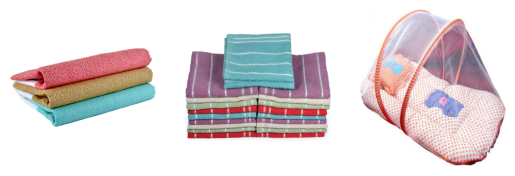

Beauty and Personal Care


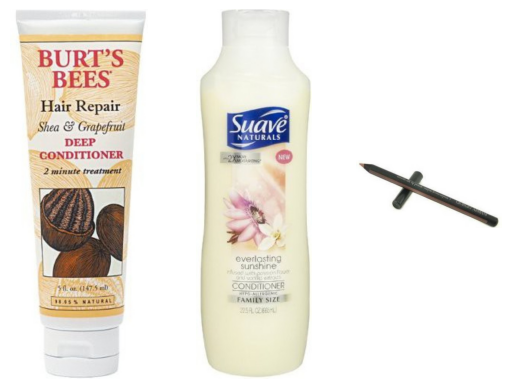

Computers


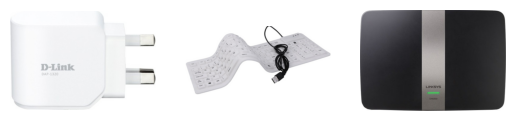

Home Decor  Festive Needs


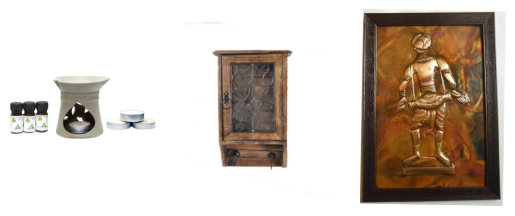

Home Furnishing


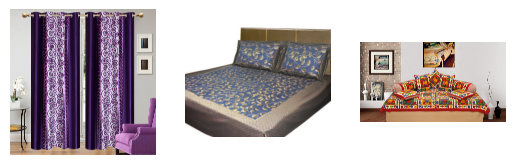

Kitchen  Dining


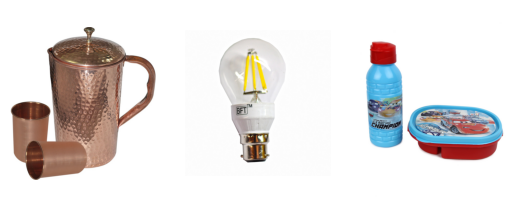

Watches


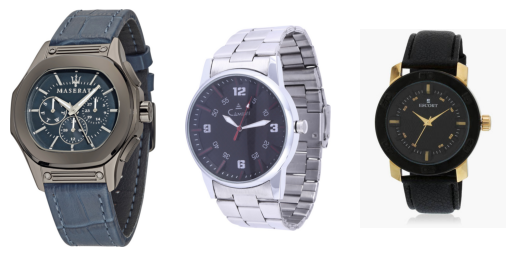

In [20]:
def list_fct(name, data):
    return [data["image_path"][i] for i in range(len(data)) if data["label_name"][i] == name]

list_labels = ["Baby Care", "Beauty and Personal Care", "Computers", "Home Decor  Festive Needs", "Home Furnishing", "Kitchen  Dining", "Watches"]

for name in list_labels:
    print(name)
    image_paths = list_fct(name, train_data) 
    for i in range(min(3, len(image_paths))):  
        plt.subplot(130 + 1 + i)
        image = imread(image_paths[i])
        plt.imshow(image)
        plt.axis('off')  
    plt.show()

- Déterminatio des paramètres SIFT

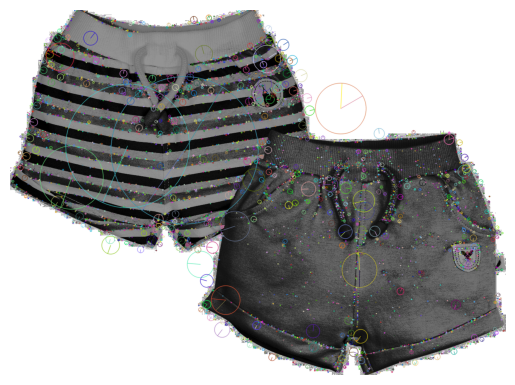

Descripteurs :  (4406, 128)

[[ 0.  0.  0. ...  0.  0.  2.]
 [12.  9. 21. ...  0.  0.  0.]
 [64. 53. 36. ...  0.  1.  4.]
 ...
 [21.  1.  0. ...  0.  0.  1.]
 [53.  9.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0. 14.]]


In [21]:
if len(train_data) > 0:
    image_path = train_data["image_path"][99]  
    image = cv2.imread(image_path, 0)
    image = cv2.equalizeHist(image)
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(image, None)
    img = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.axis('off')  
    plt.show()

    if des is not None:
        print("Descripteurs : ", des.shape)
        print()
        print(des)
    else:
        print("Aucun descripteur trouvé.")
else:
    print("Aucune image trouvée dans le DataFrame.")

## <a name="C4"> SIFT</a>

- Création des descripteurs pour chaque image


In [22]:
sift = cv2.SIFT_create(500)
sift_keypoints = []
temps1 = time.time()

for idx in range(len(train_data)): 
    if idx % 100 == 0: 
        print(idx)

    image_path = train_data['image_path'][idx]
    image = cv2.imread(image_path, 0)  
    res = cv2.equalizeHist(image)

    kp, des = sift.detectAndCompute(res, None)
    if des is not None:
        sift_keypoints.append(des)


sift_keypoints_by_img = [des for des in sift_keypoints if des is not None]
sift_keypoints_all = np.concatenate(sift_keypoints, axis=0)

print("\nNombre de descripteurs : ", sift_keypoints_all.shape)

duration1 = time.time() - temps1
print("Temps de traitement SIFT descriptor : ", "{:.2f}".format(duration1), "secondes")

0
100
200
300
400
500
600
700
800
900

Nombre de descripteurs :  (465414, 128)
Temps de traitement SIFT descriptor :  256.13 secondes


- Création des descipteurs des catégories

In [23]:
if 'sift_keypoints_all' in locals() and len(sift_keypoints_all) > 0:

    temps1 = time.time()
    k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
    print("Nombre de clusters estimés : ", k)
    print("Création de", k, "clusters de descripteurs ...")

    kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
    kmeans.fit(sift_keypoints_all)

    duration1 = time.time() - temps1
    print("Temps de traitement KMeans : ", "{:.2f}".format(duration1), "secondes")
else:
    print("Aucun descripteur SIFT n'a été trouvé. Veuillez d'abord exécuter le script de génération des descripteurs SIFT.")


Nombre de clusters estimés :  682
Création de 682 clusters de descripteurs ...
Temps de traitement KMeans :  6.22 secondes


- Création de variable d'image

In [24]:
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0: 
        print("Problème histogramme image : ", image_num)
    for i in res:
        hist[i] += 1.0 / nb_des
    return hist

temps1 = time.time()

hist_vectors = []

for i, image_desc in enumerate(sift_keypoints_by_img):
    if i % 100 == 0: 
        print(i)
    if image_desc is not None:
        hist = build_histogram(kmeans, image_desc, i) 
        hist_vectors.append(hist)  

im_features = np.asarray(hist_vectors)

duration1 = time.time() - temps1
print("Temps de création des histogrammes : ", "{:.2f}".format(duration1), "secondes")


0
100
200
300
400
500
600
700
800
900
Temps de création des histogrammes :  208.67 secondes


- Réduction des dimensions PCA TSNE

In [25]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = train_data["label_name"]
print(df_tsne.shape)

Dimensions dataset avant réduction PCA :  (945, 682)
Dimensions dataset après réduction PCA :  (945, 464)
(945, 3)


In [26]:
df_tsne

,tsne1,tsne2,class
0,4.502985,27.551430,Baby Care
1,-12.924165,20.160036,Baby Care
2,-17.198446,37.151600,Baby Care
3,-23.474787,-13.868159,Baby Care
4,-12.753196,2.227157,Baby Care
...,...,...,...
940,9.763138,16.043030,Watches
941,13.274522,22.017075,Watches
942,-21.303720,-23.314478,Watches
943,-15.798680,-3.803031,Watches


- Visualisation

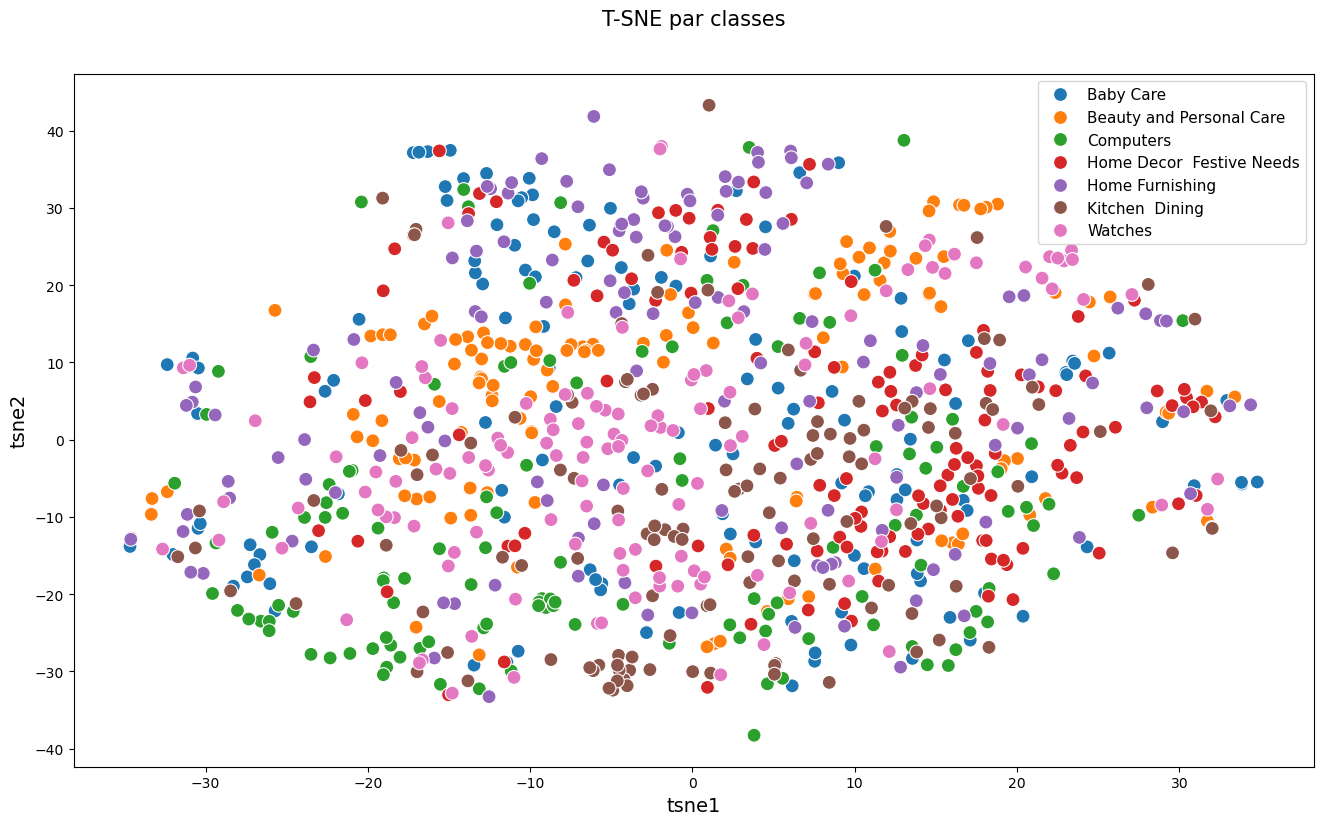

In [27]:
plt.figure(figsize=(16,9))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief", s=100, alpha=1)

plt.title('T-SNE par classes', fontsize = 15, pad = 35)
plt.xlabel('tsne1', fontsize = 14)
plt.ylabel('tsne2', fontsize = 14)
plt.legend(prop={'size': 11}) 

plt.show()

- Kmeans sur 2 composants TSNE

(945, 4)


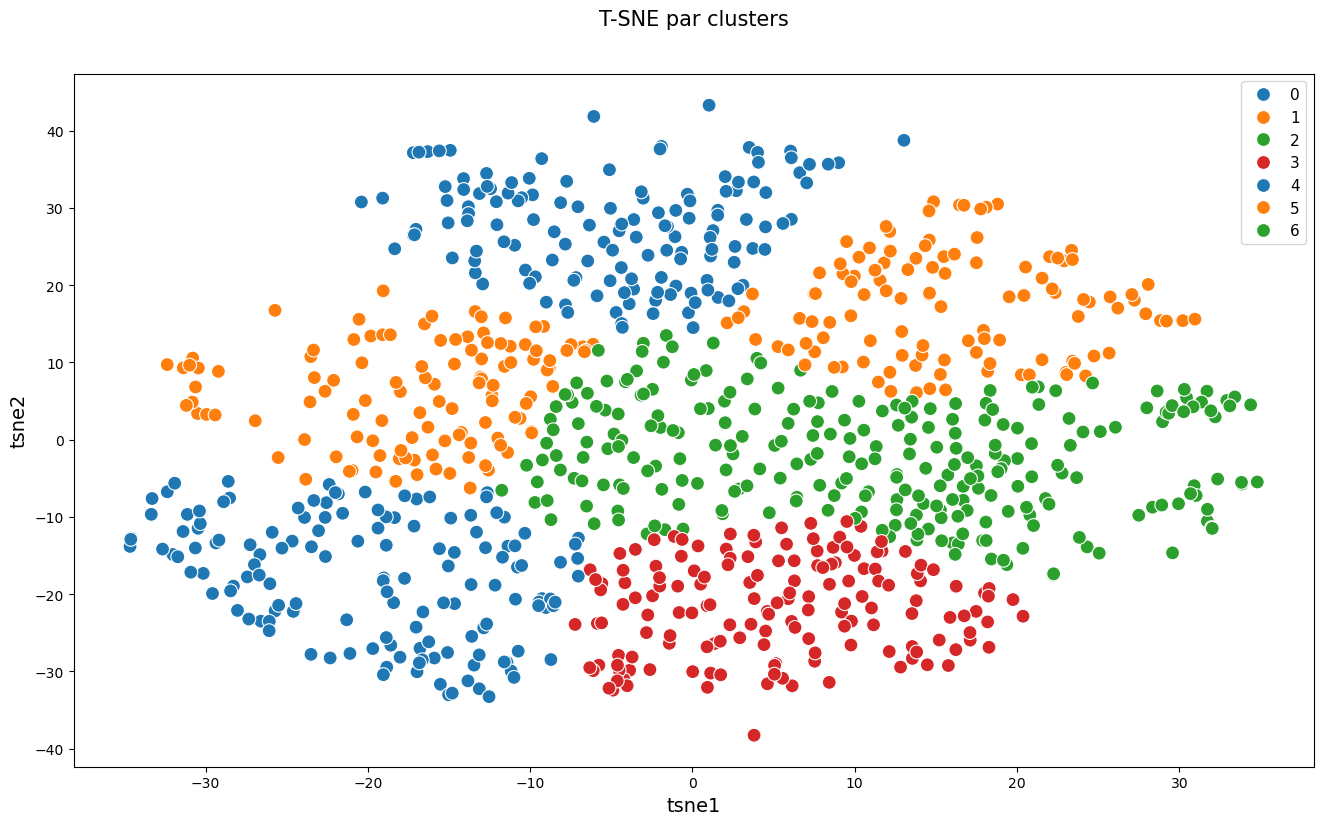

In [28]:
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)
plt.figure(figsize=(16,9))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="cluster", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=4), s=100, alpha=1)

plt.title('T-SNE par clusters', fontsize = 15, pad = 35)
plt.xlabel('tsne1', fontsize = 14)
plt.ylabel('tsne2', fontsize = 14)
plt.legend(prop={'size': 11}) 

plt.show()

In [29]:
labels = train_data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

ARI :  0.06129805621346211


## <a name="C4"> CNN transfer Learning</a>

- Création du modèle 

In [30]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


- Création de la variable image

In [31]:
images_features = []
i = 0

for image_file in train_data["image_path"]: 
    if i % 100 == 0: 
        print(i)
    i += 1

    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    features = model.predict(image, verbose=0)[0]
    images_features.append(features)

images_features = np.asarray(images_features)
print(images_features.shape)

0
100
200
300
400
500
600
700
800
900
(945, 4096)


- Réduction des dimensions

In [32]:
print("Dimensions dataset avant réduction PCA : ", images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = train_data["label_name"]
print(df_tsne.shape)

Dimensions dataset avant réduction PCA :  (945, 4096)
Dimensions dataset après réduction PCA :  (945, 728)
(945, 3)


- Visualisation

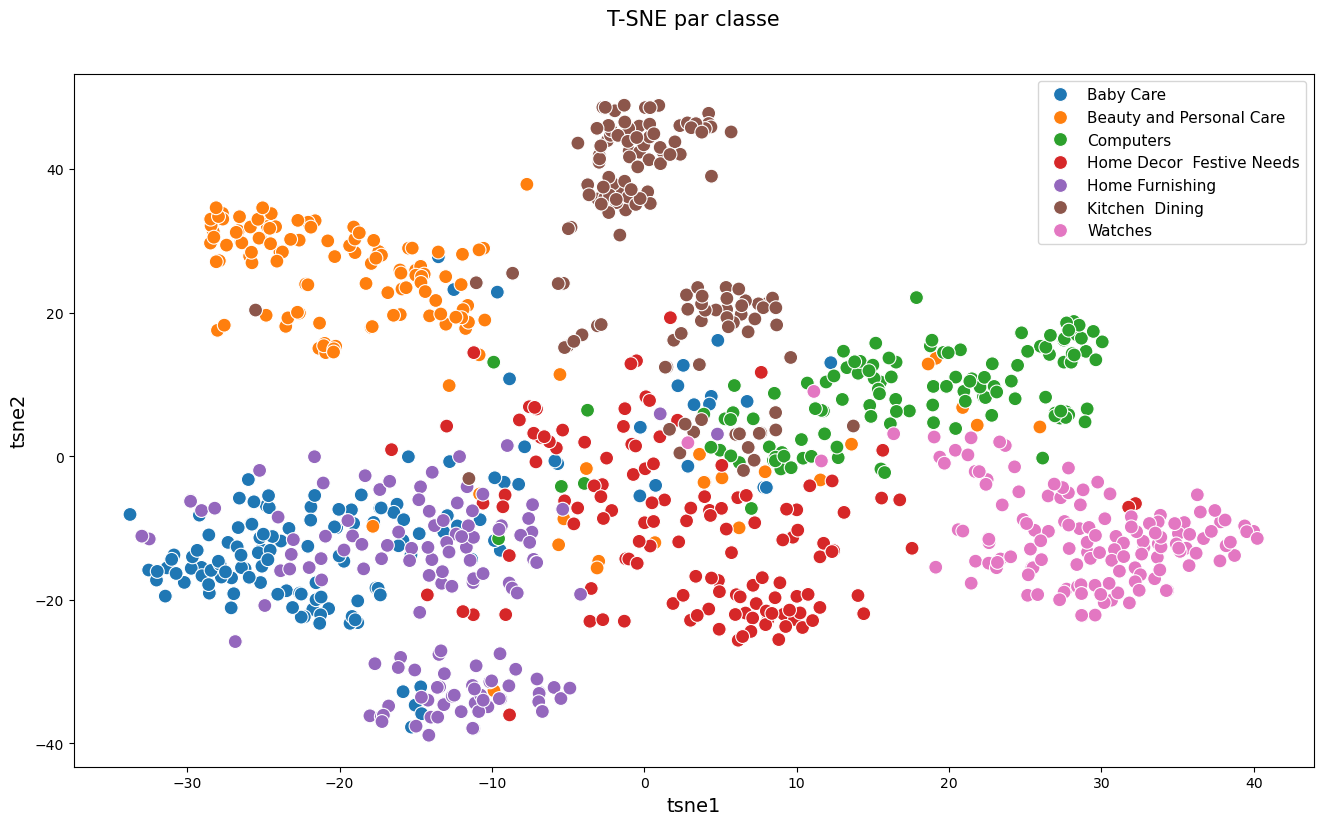

In [33]:
plt.figure(figsize=(16,9))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief", s=100, alpha=1)

plt.title('T-SNE par classe', fontsize = 15, pad = 35)
plt.xlabel('tsne1', fontsize = 14)
plt.ylabel('tsne2', fontsize = 14)
plt.legend(prop={'size': 11}) 

plt.show()

- Kmeans à 2 composantes

(945, 4)


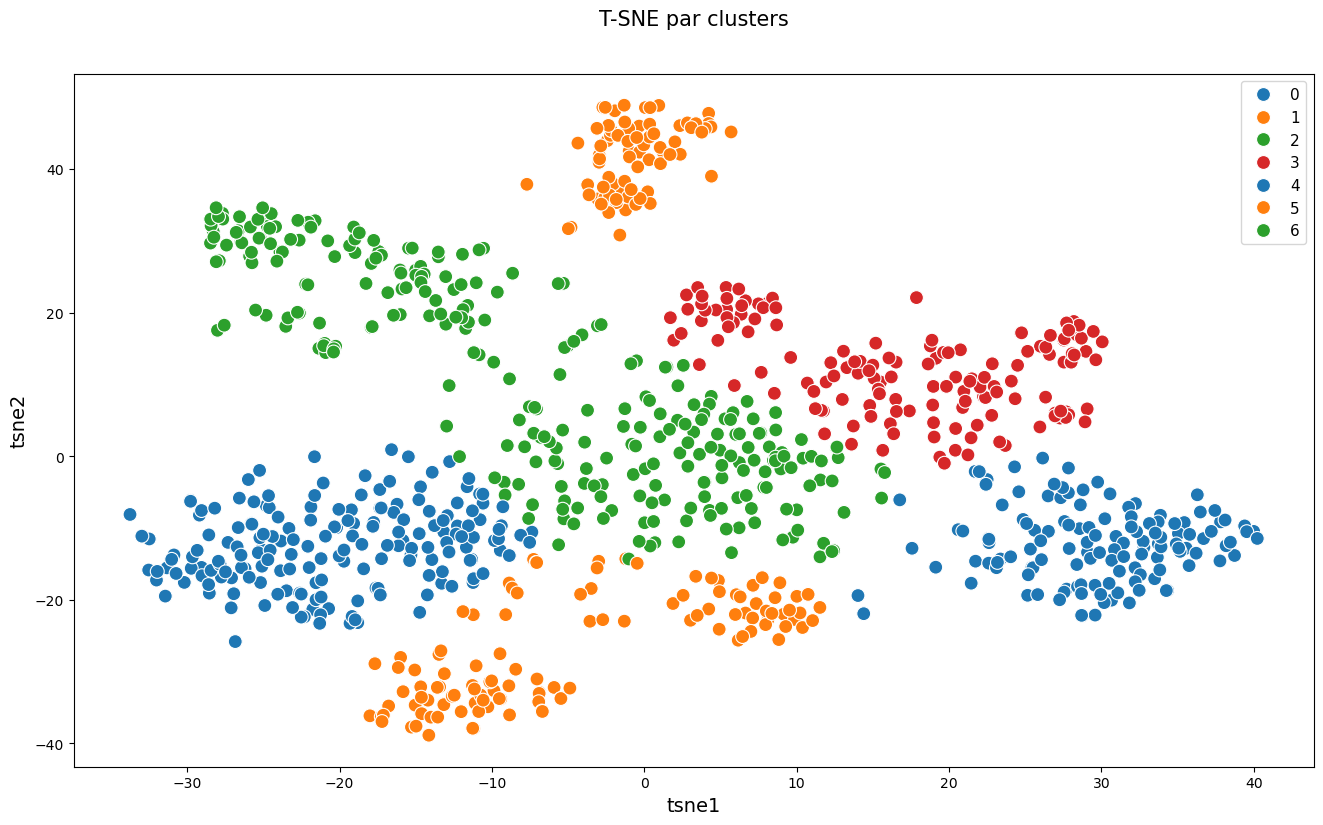

In [34]:
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

plt.figure(figsize=(16,9))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="cluster", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=4), s=100, alpha=1)

plt.title('T-SNE par clusters', fontsize = 15, pad = 35)
plt.xlabel('tsne1', fontsize = 14)
plt.ylabel('tsne2', fontsize = 14)
plt.legend(prop={'size': 11}) 

plt.show()

In [35]:
labels = train_data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

ARI :  0.4831588306504515


## <a name="C4"> Apprentissage supervisé avec CNN transfer learning</a>

- Création des modèles de classification

In [36]:
def create_VGG16_fct() :
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    for layer in model0.layers:
        layer.trainable = False

    x = model0.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    model = Model(inputs=model0.input, outputs=predictions)
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [37]:
def create_VGG16_fct2() :
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),])
    
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')])

    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    print(model.summary())
    return model
    

In [38]:
def create_VGG19_fct():
    model0 = VGG19(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    for layer in model0.layers:
        layer.trainable = False

    x = model0.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x) 

    model = Model(inputs=model0.input, outputs=predictions)
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])
    print(model.summary())
    return model

In [39]:
def create_ResNet50_fct():
    model0 = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    for layer in model0.layers:
        layer.trainable = False

    x = model0.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)  
    model = Model(inputs=model0.input, outputs=predictions)

    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])
    print(model.summary())
    return model

- Préparation

In [40]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        img = (load_img(
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np_train = image_prep_fct(train_data)
print(images_np_train.shape)

images_np_test = image_prep_fct(test_data)
print(images_np_test.shape)

(945, 224, 224, 3)
(105, 224, 224, 3)


In [41]:
y = to_categorical(train_data['label'])      
y_test = to_categorical(test_data['label'])  
X = images_np_train      
X_test = images_np_test  

In [42]:
print(y.shape)     
print(y_test.shape) 
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(945, 7)
(105, 7)


(708, 224, 224, 3)

## <a name="C4"> VGG16 simplifié</a>

- Création du modèle

In [43]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

with tf.device('/gpu:0'): 
    model1 = create_VGG16_fct()

model1_save_path1 = "./model1_best_weights.keras"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [44]:
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=25, batch_size=32, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

Epoch 1/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3699 - loss: 7.1349
Epoch 1: val_loss improved from inf to 1.35600, saving model to ./model1_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.3747 - loss: 7.0324 - val_accuracy: 0.7975 - val_loss: 1.3560
Epoch 2/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7079 - loss: 1.6154
Epoch 2: val_loss improved from 1.35600 to 1.03497, saving model to ./model1_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 333s 15s/step - accuracy: 0.7083 - loss: 1.6132 - val_accuracy: 0.8228 - val_loss: 1.0350
Epoch 3/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8012 - loss: 0.9134
Epoch 3: val_loss improved from 1.03497 to 0.97952, saving model to ./model1_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8011 - loss: 0.9150 - val_accuracy: 0.8228 - val_loss: 0.9795
Epoch 4/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8038 - loss: 0.8675
Epoch 4: val_loss improved from 0.979

- Scores

In [45]:
loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

23/23 ━━━━━━━━━━━━━━━━━━━━ 3696s 168s/step - accuracy: 0.9941 - loss: 0.0235
Training Accuracy: 0.9929

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8790 - loss: 0.6964
Validation Accuracy:  0.8565


In [46]:
model1.load_weights(model1_save_path1)
loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8608
Test Accuracy       :  0.5810


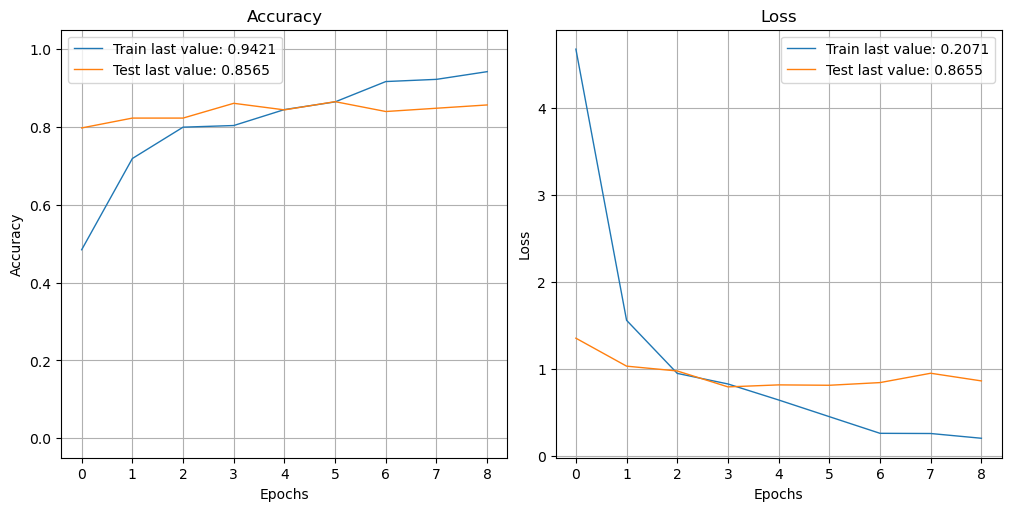

In [47]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

- Analyse des catègories

In [48]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
[4 3 3 2 2 0 4 1 4 5 6 5 5 3 1 4 6 3 4 5 1 1 2 5 0 1 2 5 0 5 6 5 0 6 0 6 5
 3 4 0 5 6 3 0 3 1 6 5 4 1 2 4 6 0 5 2 2 2 0 4 6 1 5 4 1 1 5 5 5 5 0 2 3 5
 1 1 4 3 6 1 4 2 2 5 0 3 6 1 5 4 2 3 3 4 3 3 3 5 3 3 0 5 3 1 4 5 3 1 5 4 3
 4 0 4 2 2 2 1 4 1 6 0 4 6 3 3 0 4 0 6 2 1 0 2 5 1 3 2 2 2 2 0 2 1 6 5 4 0
 0 4 1 0 6 0 6 6 5 1 3 1 6 3 2 6 1 4 5 6 4 3 4 6 0 4 0 3 6 3 4 2 1 3 6 5 2
 4 6 0 1 6 5 1 2 0 3 3 6 2 0 6 3 1 2 6 1 0 6 5 3 0 1 3 2 2 2 6 6 1 4 4 2 1
 6 0 5 0 4 5 2 5 0 0 4 1 2 0 4]

[4 3 0 2 2 0 4 1 0 5 6 5 3 3 1 4 6 3 4 5 4 3 2 5 0 1 2 5 0 5 6 5 0 6 0 6 5
 3 4 0 5 6 3 0 3 1 6 5 4 1 2 4 6 0 5 2 5 2 0 4 6 3 5 4 2 1 5 5 5 5 0 2 3 5
 1 0 4 3 6 1 4 2 0 5 0 3 6 1 5 4 2 3 3 4 3 3 3 3 3 5 0 1 3 1 0 5 3 1 5 4 6
 4 0 4 2 2 2 1 4 1 6 0 4 6 3 3 0 4 0 2 3 1 0 2 5 1 3 2 2 1 2 0 2 1 6 5 4 0
 0 4 1 0 6 0 6 2 5 1 3 1 6 3 6 6 1 4 5 6 4 3 3 6 0 0 0 3 6 3 4 2 1 3 6 5 2
 0 6 0 1 6 5 1 2 5 0 3 6 6 4 6 3 1 3 6 1 0 6 5 3 4 1 3 2 2 3 6 6 1 4 4 2 1
 6 0 5 0 4 5 2 4 0 5 4 2 2 0 4

In [49]:
def calculate_confusion_matrix(y_true, y_pred):
    categories = ["Baby Care", "Beauty and Personal Care", "Computers", 
                  "Home Decor & Festive Needs", "Home Furnishing", 
                  "Kitchen & Dining", "Watches"]

    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    conf_mat_df = pd.DataFrame(conf_mat, index=[f'Actual {categories[i]}' for i in range(len(conf_mat))],
                               columns=[f'Predicted {categories[i]}' for i in range(len(conf_mat[0]))])

    classification_report = metrics.classification_report(y_true, y_pred, output_dict=True)
    class_report_df = pd.DataFrame(classification_report).transpose()
    return conf_mat_df, class_report_df

In [50]:
confusion_matrix_df, classification_report_df = calculate_confusion_matrix(y_val_num, y_val_pred)
print("Matrice de confusion :")
confusion_matrix_df

Matrice de confusion :


,Predicted Baby Care,Predicted Beauty and Personal Care,Predicted Computers,Predicted Home Decor & Festive Needs,Predicted Home Furnishing,Predicted Kitchen & Dining,Predicted Watches
Actual Baby Care,30,0,0,0,2,2,0
Actual Beauty and Personal Care,1,28,2,2,1,0,0
Actual Computers,1,1,26,3,0,1,2
Actual Home Decor & Festive Needs,2,0,0,30,0,1,1
Actual Home Furnishing,4,0,0,1,29,0,0
Actual Kitchen & Dining,0,1,0,2,1,30,0
Actual Watches,0,0,2,0,0,0,31


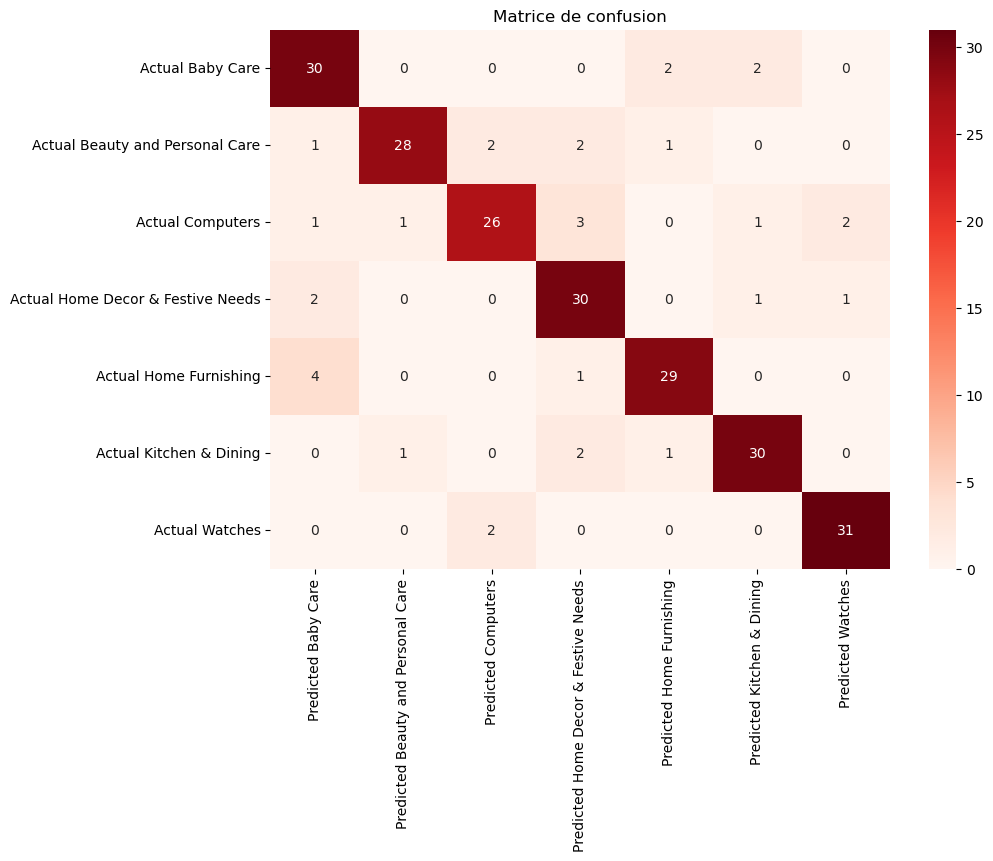

Rapport de classification :


,precision,recall,f1-score,support
0,0.789474,0.882353,0.833333,34.000000
1,0.933333,0.823529,0.875000,34.000000
2,0.866667,0.764706,0.812500,34.000000
3,0.789474,0.882353,0.833333,34.000000
4,0.878788,0.852941,0.865672,34.000000
5,0.882353,0.882353,0.882353,34.000000
6,0.911765,0.939394,0.925373,33.000000
accuracy,0.860759,0.860759,0.860759,0.860759
macro avg,0.864550,0.861090,0.861081,237.000000
weighted avg,0.864351,0.860759,0.860809,237.000000


In [51]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix_df, annot=True, cmap="Reds")
plt.title('Matrice de confusion')
plt.show()

print("Rapport de classification :")
classification_report_df

## <a name="C4"> VGG16 : Image data generator avec augmentation des données </a>

- Préparation

In [52]:
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [69]:
batch_size = 32
def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='label_name',
                                weight_col=None, target_size=(224, 224),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type)
    return data_flow

In [70]:
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25, 
    preprocessing_function=preprocess_input)
train_flow = data_flow_fct(train_data, datagen_train, data_type='training')
val_flow = data_flow_fct(train_data, datagen_train, data_type='validation')

Found 709 validated image filenames belonging to 7 classes.
Found 236 validated image filenames belonging to 7 classes.


In [71]:
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input)
test_flow = data_flow_fct(test_data, datagen_test)

Found 105 validated image filenames belonging to 7 classes.


- Création du modèle

In [72]:
with tf.device('/gpu:0'): 
    model2 = create_VGG16_fct()

model2_save_path = "./model2_best_weights.keras"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [73]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,epochs=25, batch_size=batch_size, 
                       callbacks=callbacks_list, validation_data=val_flow, verbose=1)

Num GPUs Available:  0
Epoch 1/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3885 - loss: 5.9929
Epoch 1: val_loss improved from inf to 1.44006, saving model to ./model2_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.3924 - loss: 5.9268 - val_accuracy: 0.6949 - val_loss: 1.4401
Epoch 2/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6641 - loss: 1.8955
Epoch 2: val_loss improved from 1.44006 to 0.93947, saving model to ./model2_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.6641 - loss: 1.8899 - val_accuracy: 0.8008 - val_loss: 0.9395
Epoch 3/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7582 - loss: 1.0150
Epoch 3: val_loss improved from 0.93947 to 0.82580, saving model to ./model2_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.7580 - loss: 1.0159 - val_accuracy: 0.7881 - val_loss: 0.8258
Epoch 4/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7488 - loss: 0.9171
Epoch 4: val_los

- Scores

In [74]:
loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

23/23 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9667 - loss: 0.0874
Training Accuracy   : 0.9633

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8429 - loss: 0.5691
Validation Accuracy :  0.8347


In [75]:
model2.load_weights(model2_save_path)
loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8347
Test Accuracy       :  0.5429


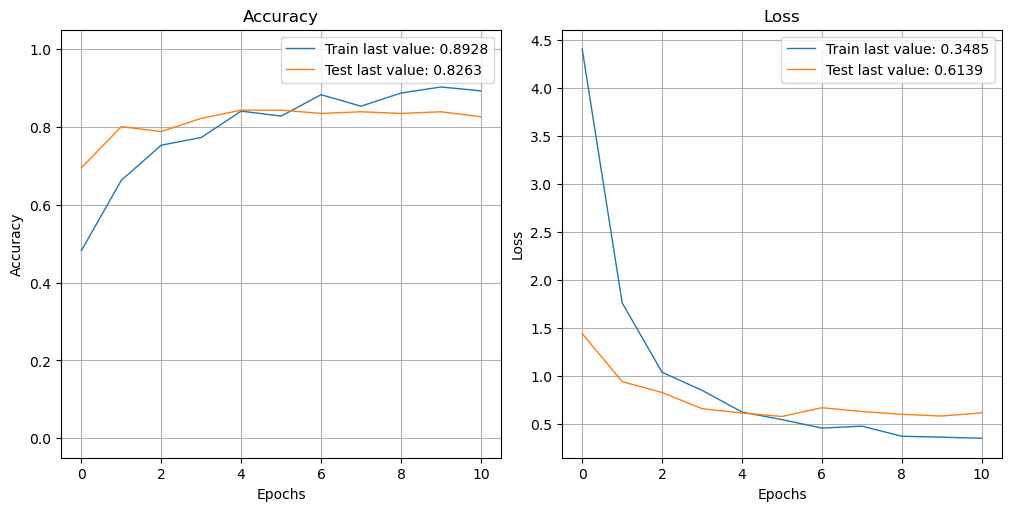

In [76]:
show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

## <a name="C4"> VGG16 : Autre méthode avec augmentation de données intégrée au dataset </a>

In [77]:
batch_size = 32
def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type)
    return dataset

In [78]:
train_path = 'Datacat/train'  
test_path = 'Datacat/test'   
dataset_train = dataset_fct(train_path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(train_path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(test_path, validation_split=0, data_type=None)

Found 945 files belonging to 7 classes.
Using 709 files for training.
Found 945 files belonging to 7 classes.
Using 236 files for validation.
Found 105 files belonging to 7 classes.


In [79]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

- Création du modèle

In [ ]:
#with tf.device('/gpu:0'): 
#    model3 = create_VGG16_fct2()
#model3_save_path = "./model3_best_weights.keras"
#checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#callbacks_list = [checkpoint, es]

In [ ]:
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#with tf.device('/gpu:0'): 
#    history3 = model3.fit(dataset_train,
#                    validation_data=dataset_val,
#                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

- Scores

In [ ]:
#loss, accuracy = model3.evaluate(dataset_train, verbose=True)
#print("Training Accuracy   : {:.4f}".format(accuracy))
#print()
#loss, accuracy = model3.evaluate(dataset_val, verbose=True)
#print("Validation Accuracy :  {:.4f}".format(accuracy))

In [ ]:
#model3.load_weights(model3_save_path)
#loss, accuracy = model3.evaluate(dataset_val, verbose=False)
#print("Validation Accuracy :  {:.4f}".format(accuracy))
#loss, accuracy = model3.evaluate(dataset_test, verbose=False)
#print("Test Accuracy       :  {:.4f}".format(accuracy))

In [ ]:
#show_history(history3)
#plot_history(history3, path="standard.png")
#plt.close()

## <a name="C4"> VGG19</a>

- Création du modèle

In [95]:
with tf.device('/gpu:0'): 
    model4 = create_VGG19_fct()
model4_save_path = "./model4_best_weights.keras"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,157,511 (76.89 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

None


In [96]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
with tf.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Num GPUs Available:  0
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3247 - loss: 8.3677
Epoch 1: val_loss improved from inf to 1.25433, saving model to ./model4_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.3299 - loss: 8.2598 - val_accuracy: 0.7331 - val_loss: 1.2543
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6457 - loss: 2.1268
Epoch 2: val_loss improved from 1.25433 to 1.09917, saving model to ./model4_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.6468 - loss: 2.1162 - val_accuracy: 0.7966 - val_loss: 1.0992
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7560 - loss: 1.1336
Epoch 3: val_loss improved from 1.09917 to 0.90934, saving model to ./model4_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.7555 - loss: 1.1347 - val_accuracy: 0.8178 - val_loss: 0.9093
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8052 - loss: 0.8397
Epoch 4: val_los

In [97]:
loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

23/23 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.9977 - loss: 0.0127
Training Accuracy   : 0.9972

8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8909 - loss: 0.5622
Validation Accuracy :  0.8475


In [98]:
model4.load_weights(model4_save_path)
loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8305
Test Accuracy       :  0.5333


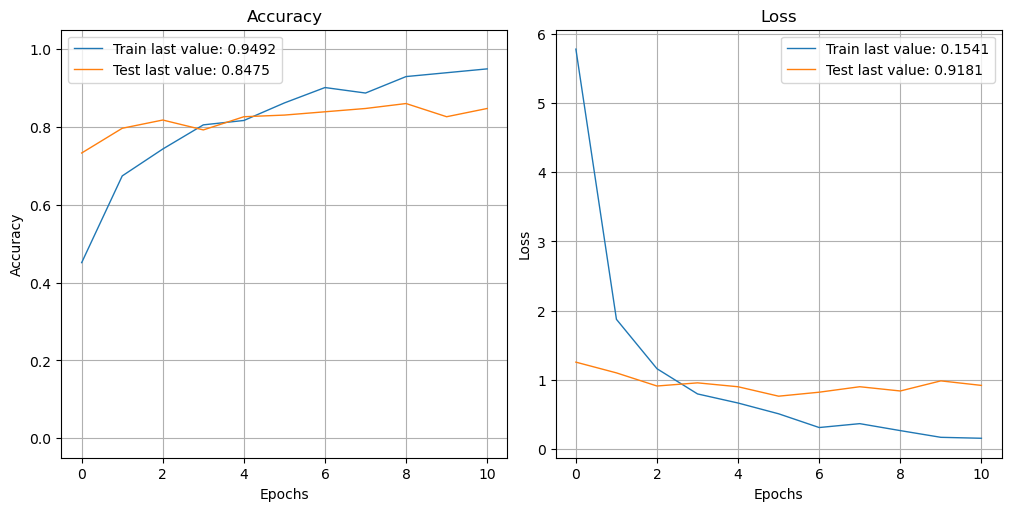

In [99]:
show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

## <a name="C4"> RESNET50</a>

In [100]:
with tf.device('/gpu:0'): 
    model5 = create_ResNet50_fct()
model5_save_path = "./model5_best_weights.keras"
checkpoint = ModelCheckpoint(model5_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_30[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


In [101]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
with tf.device('/gpu:0'): 
    history5 = model5.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Num GPUs Available:  0
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4364 - loss: 2.3749
Epoch 1: val_loss improved from inf to 0.62598, saving model to ./model5_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4412 - loss: 2.3451 - val_accuracy: 0.7924 - val_loss: 0.6260
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7768 - loss: 0.7545
Epoch 2: val_loss improved from 0.62598 to 0.58639, saving model to ./model5_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7765 - loss: 0.7544 - val_accuracy: 0.8008 - val_loss: 0.5864
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7875 - loss: 0.6074
Epoch 3: val_loss improved from 0.58639 to 0.42372, saving model to ./model5_best_weights.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7883 - loss: 0.6065 - val_accuracy: 0.8729 - val_loss: 0.4237
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8898 - loss: 0.3813
Epoch 4: val_los

In [102]:
loss, accuracy = model5.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model5.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9706 - loss: 0.0937
Training Accuracy   : 0.9788

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8168 - loss: 0.5731
Validation Accuracy :  0.8390


In [103]:
model5.load_weights(model5_save_path)

loss, accuracy = model5.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model5.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.8729
Test Accuracy       :  0.6000


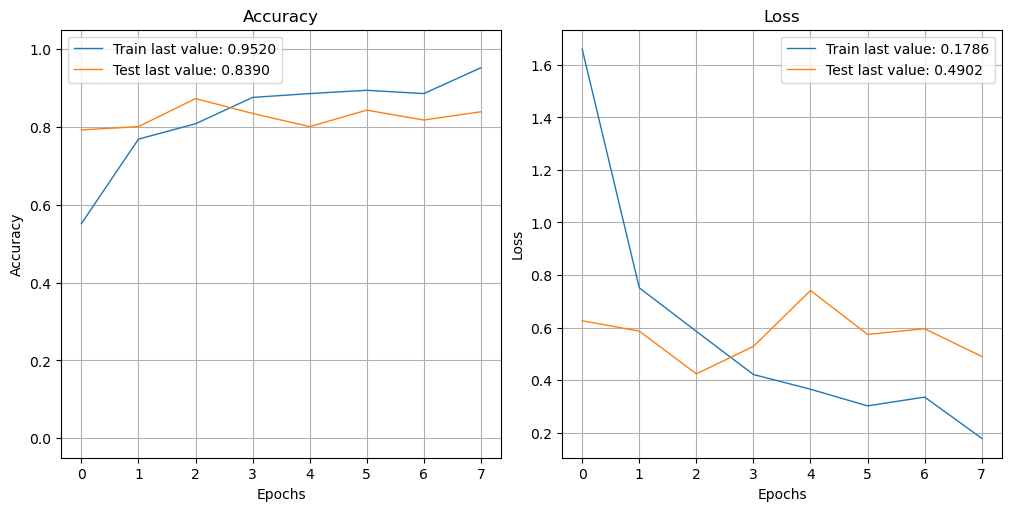

In [104]:
show_history(history5)
plot_history(history5, path="standard.png")
plt.close()

## <a name="C4"> Conclusion</a>


Notre mission consistait à évaluer la faisabilité de la classification automatique des articles sur notre marketplace à partir des descriptions textuelles et des images. À travers ce projet, nous avons exploré diverses techniques de prétraitement, d'extraction de features et de réduction dimensionnelle pour analyser et visualiser les données. Les résultats obtenus nous permettront de déterminer si une telle automatisation est viable et comment elle pourrait améliorer l'expérience utilisateur. En conclusion, cette étude de faisabilité est une étape cruciale vers la mise en place d'un système de classification robuste et efficace, facilitant la mise en ligne des articles par les vendeurs et la recherche de produits par les acheteurs.